# Introduction




In [9]:
#| echo: false


import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from rustworkx import PyDiGraph
import rustworkx as rx
from rustworkx.visualization import mpl_draw



def ngram_label(node_data):
    return node_data


def generate_de_bruijn_graph(vocabulary, k):
    # Generate all possible k-mers
    k_mers = [''.join(p) for p in product(vocabulary, repeat=k)]
    
    # Create a directed graph
    G = rx.PyDiGraph()
    
    # Add nodes to the graph
    node_indices = {k_mer: G.add_node(k_mer) for k_mer in k_mers}
    
    # Add edges to the graph
    for k_mer in k_mers:
        for letter in vocabulary:
            next_k_mer = k_mer[1:] + letter
            if next_k_mer in node_indices:
                G.add_edge(node_indices[k_mer], node_indices[next_k_mer], None)
    
    return G




# Methods for Analyzing Transformers and N-Grams

## N-Grams and the de Bruijn Graph

The [de Bruijn graph](https://en.wikipedia.org/wiki/De_Bruijn_graph) $B_{m,n}$ is a directed graph, where each vertex $v \in V$ represents an $n$-tuple of $m$ distinct characters $C$. We can think of an $n$-tuple in a de Bruijn graph as a queue that always has $n$ elements. New characters from the vocabulary added to the right hand side and popped off the left hand side. For a de Bruijn graph with $(n-1)$-element tuples, there is an edge if we can get from one set of characters to another by adding an element on the right and removing the left-most element.  

Consider $B_{3,2}$, shown in @fig-b32 on the vocabulary $\{0, 1\}$. There is a directed edge from node $(t_1, t_2, t_3) \mapsto (s_1, s_2, s_3)$ if $t_2 = s_1$ and $t_3 = s_2$. So for $B_{3, 2}$ there are edges $(0, 0, 1) \mapsto (0, 1, 0)$ and $(0, 1, 0) \mapsto (1, 0, 1)$, but no edge from $(0, 0, 1)$ to $(1, 0, 1)$.

We can consider a text sequence as a _walk_ on the de Bruijn graph. The sequence `aaabacabac` maps to `aa -> aa -> ab -> ba -> ac -> ca -> ab -> ba -> ac`. This is the same as the sequence of bigrams (2-grams) and in general a sequence of $n$-grams can be encoded as a walk on $B_{m, n}$. There is a directed edge between one node and another precisely when the next node can be the next $n$-gram. We can't map `ab -> ac` because that would "change history" and make it such that `b` had never come after `a`.

Note that as $n$ increases, $B_{n,m}$ gets increasingly sparse--there are $m^{n}$ nodes, but each node only ever has $m$ in-going and $m$ out-going edges. 

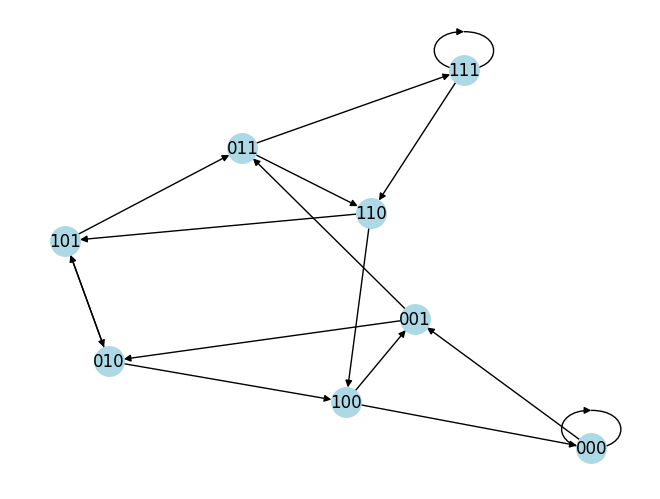

In [19]:
#| echo: false
#| label: fig-b32
#| width: 100
#| fig-cap: "The de Bruijn graph $B_{3, 2}$"
# Set vocabulary and k
vocabulary = ['0', '1']
k = 3

# Generate the graph
graph = generate_de_bruijn_graph(vocabulary, k)

mpl_draw(graph, with_labels=True, node_color='#ADD8E6', labels=ngram_label, node_size=450)


The $n$-gram distribution $\nu_n$ for a given corpus of sequences is a probability distribution over the "next" character given the previous $n-1$.^[The $n$th character is the one being predicted.] We can view the $n$-gram probability distribution as a function on the associated de Bruijn graph, $G_{n}: B_{n-1, m} \rightarrow \mathbb{R}^n$.^[The de Bruijn graph on $n-1$ vertices because the distribution is conditioned on $n-1$ characters.] For each vertex $v \in B_{n-1, m}$:
$$ \nu_{n}(v) = p(x_{t+1} | x_{t} = v_{n-1}, \dots, x_{t-n+1} = v_{1})$$

As we increase $n$, $\nu_{n}$ becomes a better and better representation of the ground truth distribution for a corpus. Our basic hypotheses are that:
1. A neural network will learn something close to $\nu_{n}$ (for perhaps large $n$).
2. We will be able to analyze and interpret a neural network by comparing it to $\nu_{n}$.

## Establishing the Connection Between a Neural Network and $\nu_{n}$

Before proceeding with analyzing a neural model with respect to the $n$-gram distribution we need to establish that the distribution the model gives on sequences is sufficiently similar to an $n$-gram model. Additionally an $n$-gram distributions assume that the the distribution of the next character is _fixed_ conditional on the prior $n-1$ characters. 

### Do Transformer Models Learn N-Grams?

The simplest way to check whether or not a transformer is learning an $n$-gram distribution $\nu_n$ is to just compare the transformer's distribution to $\nu_n$. There are many divergences on discrete probability spaces, but one of the most important is the [Kullback-Liebler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). For two measures $P, Q$  on a discrete probability space $\chi$, the KL divergence $D_{KL}$ is:

$$ D_{KL}(P || Q) = \sum_{x \in \chi} P(x)\log[\frac{P(x)}{Q(x)}]$$

In our case the sample space is $n$-tuples of characters $C^n$. We can get a good estimate of the KL-divergence by just sampling $c \in C^{n-1}$ uniformly from the corpus and calculating the KL divergence of the _conditional_ distributions:
$\mathbb{E}_{c \in C^{n-1}}[D_{KL}(T(\cdot | c) || \nu_{n}(\cdot | c)]$

We have done these calculations for transformer models trained on [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories), which you can see in @fig-ngram-kl


![KL Divergence between an 8 layer transformer and the N-Gram distribution over the course of training.](ngram_kl_eight_layers.png){#fig-ngram-kl}





### How Much Do Transformer Models Depend on Prior Context?

An assumption in an $n$-gram probability distribution is that probability of token is dependent _only_ on the previous $n-1$  tokens: $p(c_{t+1} = c) = p(c_{t+1} = p(c | c_t, ..., c_{t-n+1}) $. All of the prior context does not matter at all. This is obviously a simplification for "true" language, but for $n$-grams to be a useful lens we need to confirm the extent to which it is true for neural language models.


There are two ways 